# model participant behavior analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["OMP_NUM_THREADS"] = "1"
import seaborn as sns 
import ast
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FixedLocator
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings("ignore")
from scipy.spatial.distance import correlation 
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr


In [2]:
output_dir = r"10_RL_agent_TDlearn_output_same_trials_data_model_participants_behavior_analysis"
os.makedirs(output_dir, exist_ok=True)
folder_path = '10_RL_agent_TDlearn_output_same_trials_data'

df_participants = []


for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        df_participants.append(df)


In [3]:
df_participants[0]

,myCard,distribution,model_choice_greedy,model_choice_softmax,model_choice_wsls,model_choice_rs,model_choice_dualQ,model_choice_dualQ_no_eta,participant_choice,model_outcome_greedy,model_outcome_softmax,model_outcome_wsls,model_outcome_rs,model_outcome_dualQ,model_outcome_dualQ_no_eta,arrowRT,spaceRT,risk,block_type,participant_outcome
0,1,high,0,0,1,1,0,0,0,1,1,0,0,1,1,1707,2607,0.0,high,1
1,1,low,1,1,0,0,0,0,0,0,0,1,1,1,1,421,1557,0.0,low,1
2,1,low,1,1,1,0,1,1,0,0,0,0,1,0,0,616,1593,0.0,low,1
3,1,low,0,0,1,0,0,0,0,1,1,0,1,1,1,884,2763,0.0,low,1
4,1,low,0,0,0,0,0,0,0,1,1,1,1,1,1,662,1584,0.0,low,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,9,uniform,1,1,0,1,1,0,1,1,1,0,1,1,0,479,2966,0.0,uniform,1
177,9,uniform,1,1,0,1,1,0,1,1,1,0,1,1,0,677,1282,0.0,uniform,1
178,9,uniform,1,1,0,1,1,0,1,1,1,0,1,1,0,276,1285,0.0,uniform,1
179,9,uniform,0,1,1,0,1,1,1,0,1,1,0,1,1,301,1398,0.0,mix,1


In [4]:
def frobenius_similarity(A, B):
    return 1 - (np.linalg.norm(A - B) / (np.linalg.norm(A) + np.linalg.norm(B)))


def permutation_test_frobenius(A, B, n_permutations=1000, seed=0):
    np.random.seed(seed)
    observed = frobenius_similarity(A, B)
    null_distribution = []

    for _ in range(n_permutations):
        perm = np.random.permutation(B.shape[0])
        permuted_B = B[perm][:, perm]
        score = frobenius_similarity(A, permuted_B)
        null_distribution.append(score)

    null_distribution = np.array(null_distribution)
    p_value = np.mean(null_distribution >= observed)
    
    return observed, p_value

# model choice vs participant choice RSA

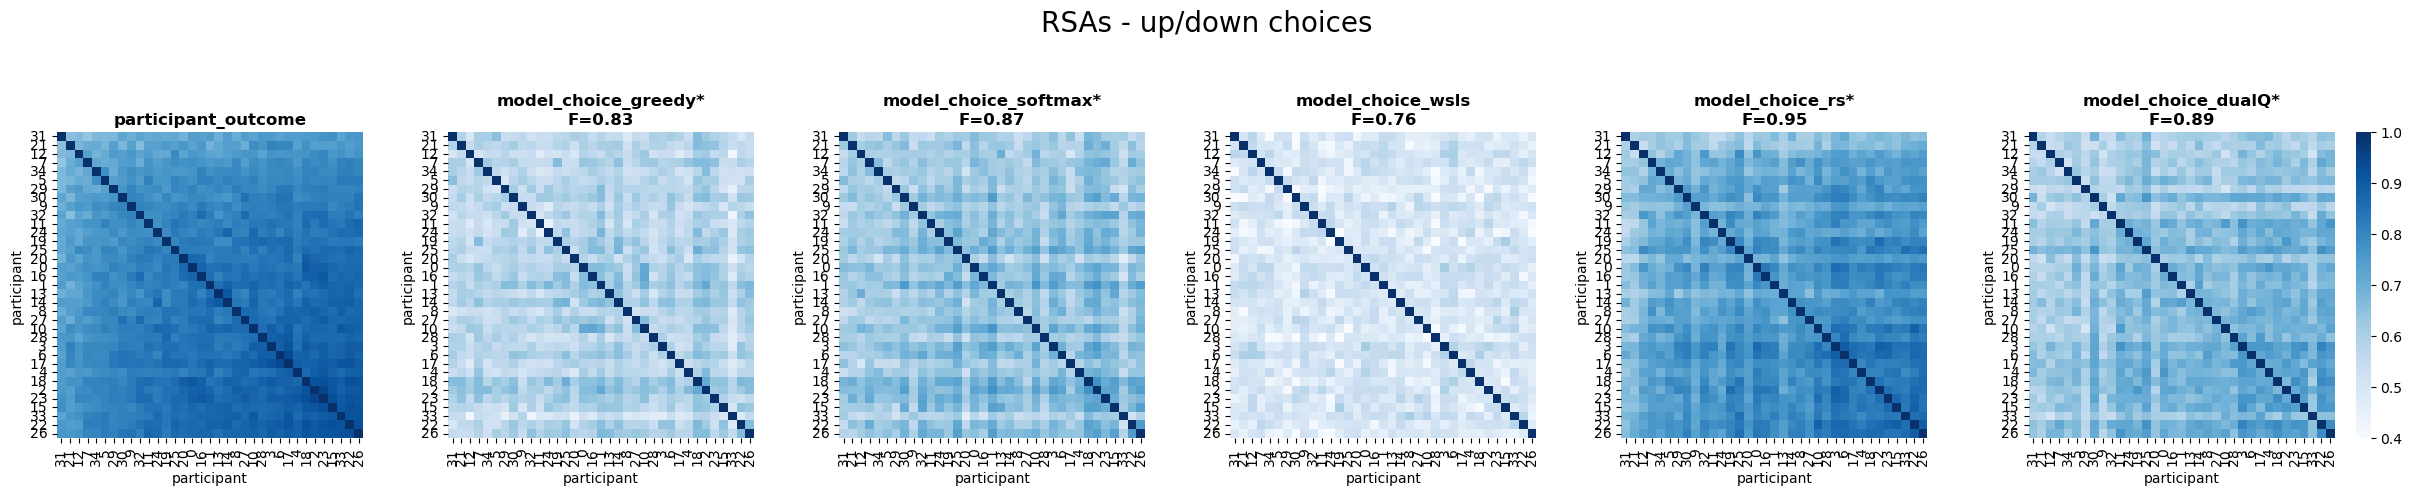

In [5]:
participant_vectors = [df['participant_choice'].values for df in df_participants]
participant_matrix = np.vstack(participant_vectors)
rsa_participant = cosine_similarity(participant_matrix)

dissimilarity = 1 - rsa_participant
np.fill_diagonal(dissimilarity, 0)
linkage_matrix = linkage(squareform(dissimilarity), method='average')
ordered_indices = leaves_list(linkage_matrix)

model_columns = [
    'model_choice_greedy',
    'model_choice_softmax',
    'model_choice_wsls',
    'model_choice_rs',
    'model_choice_dualQ'
]

rsa_matrices = {}
frobenius_scores = {}
significance_flags = {}

rsa_participant_ordered = rsa_participant[ordered_indices][:, ordered_indices]

for col in model_columns:
    model_vectors = [df[col].values for df in df_participants]
    model_matrix = np.vstack(model_vectors)
    rsa_model = cosine_similarity(model_matrix)
    rsa_model_ordered = rsa_model[ordered_indices][:, ordered_indices]
    rsa_matrices[col] = rsa_model_ordered

    frob, p_val = permutation_test_frobenius(rsa_participant_ordered, rsa_model_ordered)
    frobenius_scores[col] = frob
    significance_flags[col] = (p_val < 0.05)

rsa_matrices = {'participant_outcome': rsa_participant_ordered, **rsa_matrices}

n = len(rsa_matrices)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4), constrained_layout=True)
vmin, vmax = 0.4, 1
labels = [str(i) for i in ordered_indices]

for ax, (title, rsa) in zip(axes, rsa_matrices.items()):
    sns.heatmap(
        rsa,
        ax=ax,
        cmap='Blues',
        square=True,
        xticklabels=labels,
        yticklabels=labels,
        vmin=vmin,
        vmax=vmax,
        cbar=(ax == axes[-1])
    )
    if title == 'participant_outcome':
        ax.set_title(title, fontweight='bold')
    else:
        frob = frobenius_scores[title]
        sig = '*' if significance_flags[title] else ''
        ax.set_title(f"{title}{sig}\nF={frob:.2f}", fontweight='bold')
    ax.set_xlabel('participant')
    ax.set_ylabel('participant')

plt.suptitle('RSAs - up/down choices', fontsize=20, y= 1.2)
filename = os.path.join(output_dir, "RSA_choice.pdf")
plt.savefig(filename, format='pdf', bbox_inches='tight')
plt.show()


# model outcome vs participant outcome

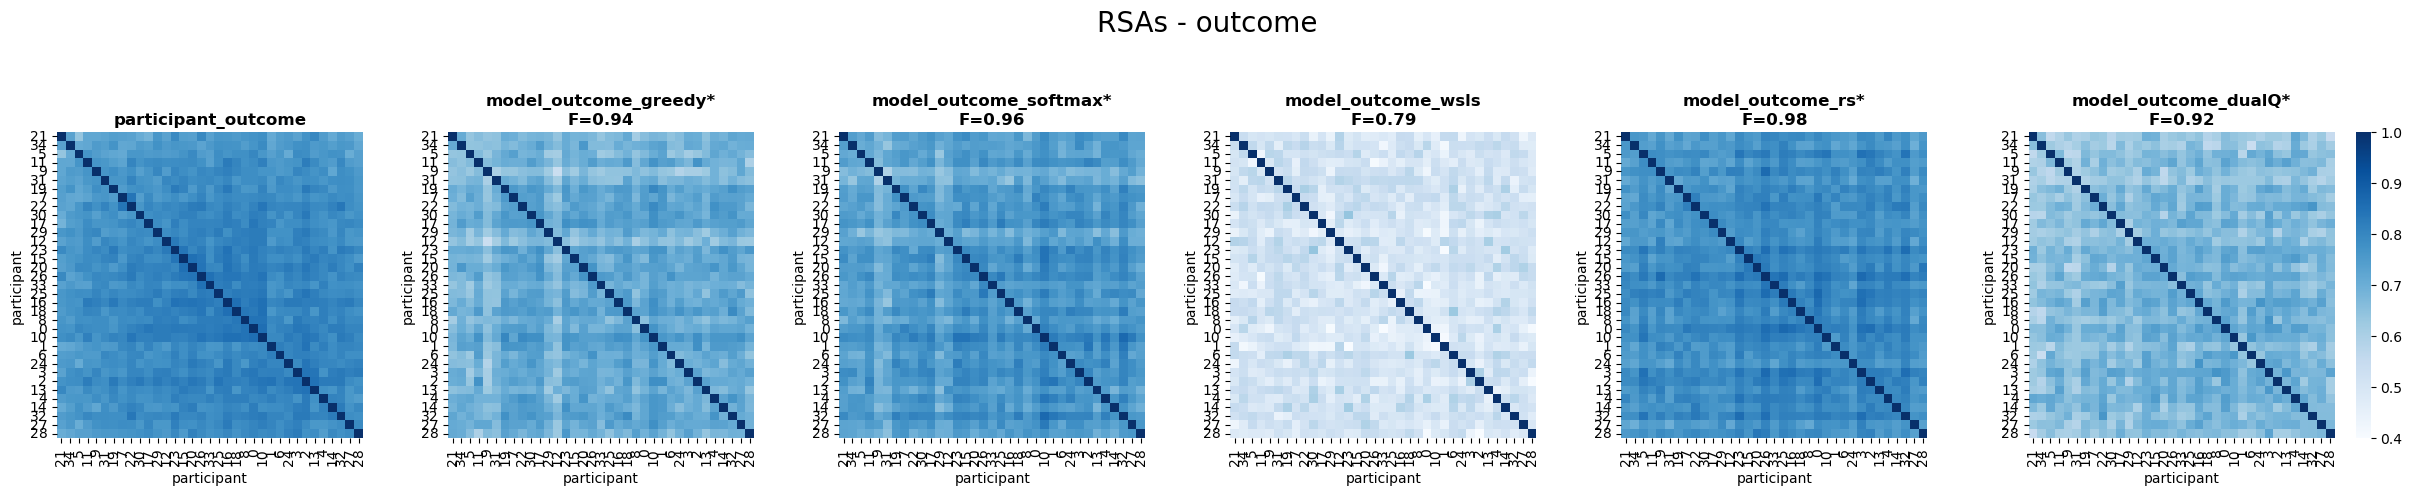

In [6]:
participant_vectors = [df['participant_outcome'].values for df in df_participants]
participant_matrix = np.vstack(participant_vectors)
rsa_participant = cosine_similarity(participant_matrix)

dissimilarity = 1 - rsa_participant
np.fill_diagonal(dissimilarity, 0)
linkage_matrix = linkage(squareform(dissimilarity), method='average')
ordered_indices = leaves_list(linkage_matrix)

model_columns = [
    'model_outcome_greedy',
    'model_outcome_softmax',
    'model_outcome_wsls',
    'model_outcome_rs',
    'model_outcome_dualQ'
]

rsa_matrices = {}
frobenius_scores = {}
significance_flags = {}

rsa_participant_ordered = rsa_participant[ordered_indices][:, ordered_indices]

for col in model_columns:
    model_vectors = [df[col].values for df in df_participants]
    model_matrix = np.vstack(model_vectors)
    rsa_model = cosine_similarity(model_matrix)
    rsa_model_ordered = rsa_model[ordered_indices][:, ordered_indices]
    rsa_matrices[col] = rsa_model_ordered

    frob, p_val = permutation_test_frobenius(rsa_participant_ordered, rsa_model_ordered)
    frobenius_scores[col] = frob
    significance_flags[col] = (p_val < 0.05)

rsa_matrices = {'participant_outcome': rsa_participant_ordered, **rsa_matrices}

n = len(rsa_matrices)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4), constrained_layout=True)
vmin, vmax = 0.4, 1
labels = [str(i) for i in ordered_indices]

for ax, (title, rsa) in zip(axes, rsa_matrices.items()):
    sns.heatmap(
        rsa,
        ax=ax,
        cmap='Blues',
        square=True,
        xticklabels=labels,
        yticklabels=labels,
        vmin=vmin,
        vmax=vmax,
        cbar=(ax == axes[-1])
    )
    if title == 'participant_outcome':
        ax.set_title(title, fontweight='bold')
    else:
        frob = frobenius_scores[title]
        sig = '*' if significance_flags[title] else ''
        ax.set_title(f"{title}{sig}\nF={frob:.2f}", fontweight='bold')
    ax.set_xlabel('participant')
    ax.set_ylabel('participant')

plt.suptitle('RSAs - outcome', fontsize=20, y=1.2)
filename = os.path.join(output_dir, "RSA_outcome.pdf")
plt.savefig(filename, format='pdf', bbox_inches='tight')
plt.show()
